In [107]:
# import requests
# import os

# # 모델의 raw URL을 사용합니다.
# url = 'https://github.com/NostalgicJ/Quantum_2023/raw/test/RNN_Practice/8/saved_models/SimpleRNN_model.h5'
# response = requests.get(url, allow_redirects=True)

# # 현재 코드 파일이 위치한 디렉토리의 상위 디렉토리로 이동
# parent_directory = os.path.join(os.getcwd(), '..')

# # 상위 디렉토리에 새로운 디렉토리 생성
# new_directory = os.path.join(parent_directory, 'my_models')

# if not os.path.exists(new_directory):
#     os.makedirs(new_directory)

# # 모델 저장하기
# with open('../my_models/SimpleRNN_model.h5', 'wb') as f:
#     f.write(response.content)
    

In [108]:
from tensorflow.keras.models import load_model

loaded_model = load_model('saved_test_models/SimpleRNN_test_model.h5')

In [109]:
# from tensorflow.keras.utils import plot_model
# import os

# # 원하는 디렉토리 지정
# directory_path = '../model_plot'
# file_name = 'SimpleRNN_model_plot.png'
# full_path = os.path.join(directory_path, file_name)

# # 모델 구조 시각화
# plot_model(loaded_model, to_file=full_path, show_shapes=True, show_layer_names=True)


In [110]:
import numpy as np
import random
from math import *
import cmath
from scipy.linalg import expm
from scipy.linalg import fractional_matrix_power

# pauli matrix
sx = np.array([[0, 1], [1, 0]])
sy = np.array([[0, -1j], [1j, 0]])
sz = np.array([[1, 0], [0, -1]])
s0 = np.array([[1, 0], [0, 1]])

# Detunning Factor
d0 = 0.15
v0 = 0.02

def Rx(theta):
    return np.matrix([[cos(theta/2),     -1j*sin(theta/2)],
                    [-1j*sin(theta/2),     cos(theta/2)]])

def Rz(phi): # Rz는 사용하지 않음. 해밀토니안에 의한 회전으로만 컨트롤
    return np.matrix([[cos(phi/2)-1j*sin(phi/2),       0],
                     [0,                          cos(phi/2)+1j*sin(phi/2)]])

def unitary(dt, choice) :
    choice_list = [0,1,-1,1,-1] # x,y-rotiation 방향 선택
    if choice <3 :
        Ham = (d0*sz+v0*choice_list[choice]*sx)
    else :
        Ham = (d0*sz+v0*choice_list[choice]*sy)
    eigvals = np.linalg.eigh(Ham)[0]
    eigvecs = 1*np.linalg.eigh(Ham)[1]
    E = np.diag(eigvals)
    U_H = eigvecs.conj().T
    U_e = U_H.conj().T @ expm(-1j*E*dt) @ U_H
    return U_e

def state_fidelity(rho_1, rho_2): 
    if np.shape(rho_1) != np.shape(rho_2):
            print("Dimensions of two states do not match.")
            return 0
    else:
        sqrt_rho_1 = fractional_matrix_power(rho_1, 1 / 2)
        fidelity = np.trace(fractional_matrix_power(sqrt_rho_1 @ rho_2 @ sqrt_rho_1, 1 / 2)) ** 2
        return np.real(fidelity)




init_wave = np.array([[1],[0]])
irho_init = np.kron(init_wave,init_wave.conj().T)

def fidelity(target_theta,target_phi) :
    target_U = Rz(target_phi) @ Rx(target_theta)
    irho_target = target_U @ irho_init @target_U.conj().T

    # 모델로 예측
    new_theta = np.array(target_theta).reshape(-1,1)
    new_phi = np.array(target_phi).reshape(-1,1)
    predicted_sequence = loaded_model.predict([new_theta, new_phi])

    # 결과 출력 (예측값은 확률 분포로 나올 것이므로 가장 높은 확률을 가진 인덱스를 선택)
    predicted_sequence_indices = np.argmax(predicted_sequence, axis=-1)


    Uni = s0
    U_0 = unitary(2.6,0)
    U_1 = unitary(2.6,1)
    U_2 = unitary(2.6,2)
    U_3 = unitary(2.6,3)
    U_4 = unitary(2.6,4)
    pulse_list = [U_0,U_1,U_2,U_3,U_4]
    for i in predicted_sequence_indices[0]:
        Uni = pulse_list[i] @ Uni

    irho_final = Uni @ irho_init @ Uni.conj().T
    
    F = (state_fidelity(irho_final,irho_target))
    
    return  F

In [111]:
sum = 0
iter = 10000
fidelities = []
low_fidelities = {'theta':[], 'phi':[], 'fidelity':[]}

for i in range(iter) :     
     # 새로운 theta와 phi 값 정의
     #target_theta = np.pi/180*random.uniform(0,180)  # 예시 값
     target_theta = np.pi/180*random.uniform(0,180)
     target_phi = np.pi/180*random.uniform(0,360)   # 예시 값
     temp = fidelity(target_theta, target_phi)
     fidelities.append(temp)
     if temp < 0.99:
          low_fidelities['theta'].append(target_theta)
          low_fidelities['phi'].append(target_phi)
          low_fidelities['fidelity'].append(temp)
     sum += temp
print(sum/iter)

1/1 [==============================] - 0s 17ms/step
0.9897388405222056


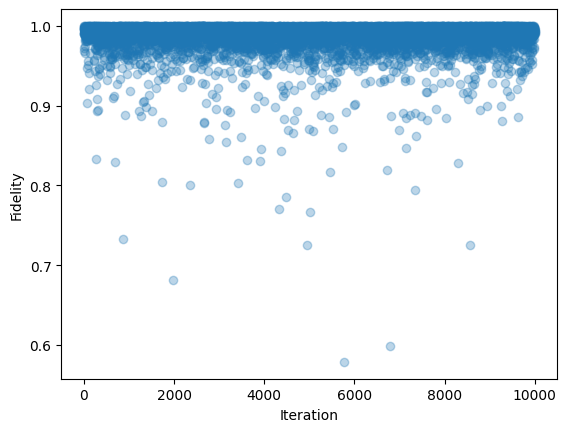

In [120]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(range(iter), fidelities, alpha=0.3)
plt.xlabel('Iteration')
plt.ylabel('Fidelity')
plt.show()

In [113]:
temp = 0
sum = 0

for i in fidelities:
     temp += 1 
     if i < 0.99:
          sum += 1
          print(temp, i)

print(sum)
print(np.std(fidelities))
print(min(fidelities))

5 0.9893241336297719
12 0.9683592869364706
13 0.971786358740849
16 0.9899499901737474
18 0.9873814186555236
20 0.9743642899023682
22 0.9897097280577551
24 0.9656954336119895
25 0.9878795142391705
27 0.9810267629810175
33 0.9836926940788939
37 0.9893178287605688
39 0.9862626670408162
42 0.9846421231865784
51 0.980552380541273
55 0.9839135240272282
61 0.9871182812347318
66 0.9808760109569507
69 0.9898590165875832
71 0.9473055412245445
73 0.9821113664102199
79 0.9030574698379339
86 0.9553992083090609
96 0.9855126565995322
101 0.9509718900544175
110 0.9895726842679663
117 0.9204529631012724
121 0.9407604630546159
125 0.9894146881999045
131 0.9870170901170722
138 0.9660392870354396
142 0.983938858147815
147 0.9817703631006817
148 0.989357486413089
150 0.9840039892609121
152 0.9867734762156118
153 0.9866258659251796
159 0.989510414164952
168 0.9838266586217396
178 0.9841034661924286
182 0.9894852387846389
183 0.9839188762140955
184 0.9857097503888594
192 0.9815596322348461
203 0.985954405546

In [114]:
print(low_fidelities)
print(low_fidelities['theta'])

{'theta': [0.8688680857555204, 1.7601515509712227, 0.62657193722005, 2.564747879573659, 0.3824382188982364, 2.2148470450664797, 0.3905788726978212, 1.2485558534653094, 2.0490785131158678, 1.590448912922709, 0.7726187995628756, 1.3532859845054115, 1.8467781963854177, 1.1184643566881403, 0.6799635107188599, 1.774845583686566, 2.455776508738452, 3.0181487507407136, 2.731202247328672, 1.9383222430999, 2.2808967025813285, 2.7513868880569308, 2.8029343418264894, 1.447390755519599, 2.6750077156259864, 2.4973739711047527, 2.765373930535407, 2.745649450802888, 1.3639470005019358, 2.5341737152685737, 1.3419437152777811, 2.7680385317645873, 1.832768972513706, 1.7564878497839505, 0.6048795481142387, 1.487070548462269, 2.2435331149302025, 1.9914834694626273, 1.9191999803987903, 2.0835705527902473, 0.1943523880830939, 2.2476997652488904, 2.034100765949151, 2.255226539258382, 1.8134258749247554, 1.8344864314588472, 2.8361656420675283, 2.793484673242588, 2.074752423427438, 0.6574257835738446, 1.297779

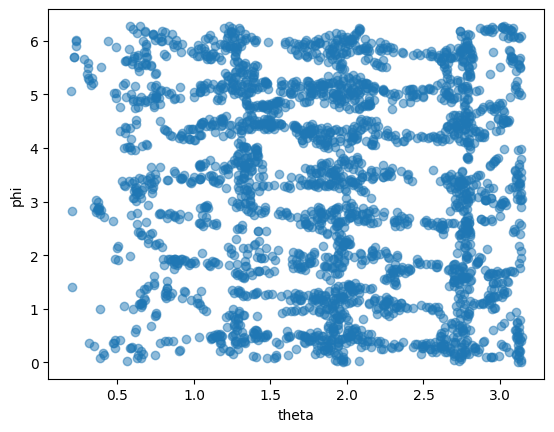

In [115]:
import matplotlib.pyplot as plt

# 그래프 표시
plt.scatter(low_fidelities['theta'], low_fidelities['phi'], alpha=0.5)
plt.xlabel('theta')
plt.ylabel('phi')
plt.show()

In [116]:
# import pandas as pd

# # 깃허브에서 CSV 파일 다운로드
# csv_url = "https://github.com/NostalgicJ/Quantum_2023/raw/test/NVspinData_None_combination_230818.csv"
# df = pd.read_csv(csv_url)

# shuffled_data = df.sample(frac=1).reset_index(drop=True)
# shuffled_data.head()

In [117]:
# # 예측 수행
# theta = shuffled_data['Theta'].values.reshape(-1, 1)
# phi = shuffled_data['Phi'].values.reshape(-1, 1)
# predictions = loaded_model.predict([theta, phi])

# # 예측 결과를 원하는 형태로 가공 (예: 가장 확률이 높은 클래스를 선택하는 경우)
# predicted_sequences = np.argmax(predictions, axis=-1)  # 이 부분은 예측 결과의 형태와 원하는 출력에 따라 조절이 필요합니다.

# # 원본 DataFrame에 예측 결과를 추가
# shuffled_data['Predicted'] = list(predicted_sequences)

In [118]:
# import os

# # 현재 코드 파일이 위치한 디렉토리의 상위 디렉토리로 이동
# parent_directory = os.path.join(os.getcwd(), '..')

# # 상위 디렉토리에 새로운 디렉토리 생성
# new_directory = os.path.join(parent_directory, 'data_results')

# if not os.path.exists(new_directory):
#     os.makedirs(new_directory)

# # 결과를 CSV 파일로 해당 디렉토리에 저장
# output_path = os.path.join(new_directory, "SimpleRNN_data_results.csv")
# shuffled_data.to_csv(output_path, index=False)

# print(f"File saved at: {output_path}")

In [119]:

# import time
# import pandas as pd

# # 빈 DataFrame 생성
# columns = ["Theta", "Phi", "Predicted Sequence", "Elapsed Time"]
# df_results = pd.DataFrame(columns=columns)

# # 각 샘플에 대한 예측과 연산 시간을 기록
# for theta, phi in zip(theta_samples, phi_samples):
#     start_time = time.time()
    
#     # 모델을 사용하여 예측 실행
#     predicted = model.predict([[theta], [phi]])
#     end_time = time.time()
    
#     elapsed_time = end_time - start_time
#     predicted_sequence = list(predicted[0])  # 첫 번째 예측 결과만 가져오기
    
#     # DataFrame에 결과 추가
#     df_results = df_results.append({
#         "Theta": theta,
#         "Phi": phi,
#         "Predicted Sequence": predicted_sequence,
#         "Elapsed Time": elapsed_time
#     }, ignore_index=True)

# # 결과를 CSV 파일에 저장
# df_results.to_csv('your_directory/your_saved_results.csv', index=False)
